In [3]:
import matplotlib.pyplot as plt
#from Bio import Entrez
import pickle as pk  
import pandas as pd

In [116]:
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t',
            skipinitialspace=True)
chem_vocabolary = pd.read_csv("input/CTD/CTD_chemicals_cleaned.txt",delimiter= '\t',
           skipinitialspace=True)

In [117]:

chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we remove the elements that do not perturb any genes:
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass



In [62]:
#Let's define a dictionary that will convert the chemical id in chemical Name
chem_id_name_conversion = {}
for i,v in chem_homo.iterrows():
    chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

In [64]:
#Let's define a dictionary that will convert the chemical id in CasRN 
chem_id_cas_conversion = {}
for i,v in chem_homo.iterrows():
    chem_id_cas_conversion[v["ChemicalID"]] = v["CasRN"]

In [125]:
gene_associations = pd.read_csv("input/Disease/all_gene_disease_associations.tsv",
           delimiter= '\t',
           skipinitialspace=True)

In [70]:
#Let's define a dictionary that will convert the disease name in disease ID
dis_name_id_conversion = {}
for i,v in gene_associations.iterrows():
        dis_name_id_conversion[v["diseaseName"]] = v["diseaseId"]

In [ ]:
#From literature we will retrieve the following key search terms:
# chme_id, dis_name
# chem_id, dis_id
# chem_name, dis_name
# chem_name, dis_id
# chem_cas,  dis_name
# chem_cas,  dis_id

In [5]:
#Let's import the proximal disease-exposure predictions
with open('output/exp_random/real_significant_final_exp_proximity.pickle', 'rb') as handle:
    real_significant_final_exp_proximity = pk.load(handle)

In [6]:
len(real_significant_final_exp_proximity)

176259

In [ ]:
#Let's look for abstracts in Pubmed with the above defined associations and synonyms
from Bio import Entrez
Entrez.email = "yourmail@gmail.com"
lit_associations_dis_chem_dict={}

for dis_chem_pair in real_significant_final_exp_proximity.keys():
    dis_chem_lit_association_list=[]
    try:
        handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_chem_pair[1],dis_chem_pair[0]), retmax=100000, usehistory = 'y', retmode="xml")
        records = Entrez.read(handle)
        dis_chem_lit_association_list.extend(records["IdList"])
    except:
        pass  
    try:
        handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_name_id_conversion[dis_chem_pair[1]],dis_chem_pair[0]), retmax=100000, usehistory = 'y', retmode="xml")
        records = Entrez.read(handle)
        dis_chem_lit_association_list.extend(records["IdList"])
    except:
        pass
    try:
        handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_chem_pair[1],chem_id_name_conversion[dis_chem_pair[0]]), retmax=100000, usehistory = 'y', retmode="xml")
        records = Entrez.read(handle)
        dis_chem_lit_association_list.extend(records["IdList"])
    except:
        pass  
    try:
        handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_name_id_conversion[dis_chem_pair[1]],chem_id_name_conversion[dis_chem_pair[0]]), retmax=100000, usehistory = 'y', retmode="xml")
        records = Entrez.read(handle)
        dis_chem_lit_association_list.extend(records["IdList"])
    except:
        pass
    try:
        handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_chem_pair[1],chem_id_cas_conversion[dis_chem_pair[0]]), retmax=100000, usehistory = 'y', retmode="xml")
        records = Entrez.read(handle)
        dis_chem_lit_association_list.extend(records["IdList"])
    except:
        pass  
    try:
        handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_name_id_conversion[dis_chem_pair[1]],chem_id_cas_conversion[dis_chem_pair[0]]), retmax=100000, usehistory = 'y', retmode="xml")
        records = Entrez.read(handle)
        dis_chem_lit_association_list.extend(records["IdList"])
    except:
        pass        
    lit_associations_dis_chem_dict[dis_chem_pair]=len(set(dis_chem_lit_association_list))


In [ ]:
with open('output/exp_random/lit_associations_dis_chem_dict_real.pickle', 'wb') as handle:
    pk.dump(lit_associations_dis_chem_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [2]:

with open('output/exp_random/lit_associations_dis_chem_dict_real.pickle', 'rb') as handle:
    lit_associations_dis_chem_dict_real = pk.load(handle)

In [3]:
len(lit_associations_dis_chem_dict_real)

176259

In [ ]:

for k,v in real_significant_final_exp_proximity.items():
    if v[1]<-12 and lit_associations_dis_chem_dict_real[k]<5 and lit_associations_dis_chem_dict_real[k]>0:
        print(k,v[1],lit_associations_dis_chem_dict_real[k])

In [22]:
exp_id_list = []
dis_name_list = []
prox_zcore_list = []
n_citations = []
for expdis,cit in lit_associations_dis_chem_dict_real.items():
    exp_id_list.append(expdis[0])
    dis_name_list.append(expdis[1])
    n_citations.append(cit)
    prox_zcore_list.append(str(round(real_significant_final_exp_proximity[expdis][1],2)))

exp_dis_cit_df = pd.DataFrame()
exp_dis_cit_df["Exposure ID"] = exp_id_list
exp_dis_cit_df["Disease Name"] = dis_name_list
exp_dis_cit_df["Proximity z-score"] = prox_zcore_list
exp_dis_cit_df["Number of Co-Citations"] = n_citations
exp_dis_cit_df.to_csv("output/exp_dis_cit_df.tsv",sep="\t")

In [11]:
lit_associations_dis_chem_dict_real_sort=dict(sorted(lit_associations_dis_chem_dict_real.items(), key=lambda item: item[1],reverse=True))


In [29]:
real_significant_final_exp_proximity['D052638', 'Hypertensive disease']

(1.5266753415744958,
 -10.119564488848892,
 (1.8625201691607025, 0.03318767600683666))

In [8]:
null_count_association=[]
for k,v in lit_associations_dis_chem_dict_real.items():
    if v==0:
        null_count_association.append(k)
print("The percentage of null found association is %s" %(len(null_count_association)/len(lit_associations_dis_chem_dict_real)))


The percentage of null found association is 0.22809615395525903


In [9]:
list_count_association=list(lit_associations_dis_chem_dict_real.values())

(-0.02519560689673284, 3.7081717488147593e-26)
SpearmanrResult(correlation=-0.11045723713163971, pvalue=0.0)


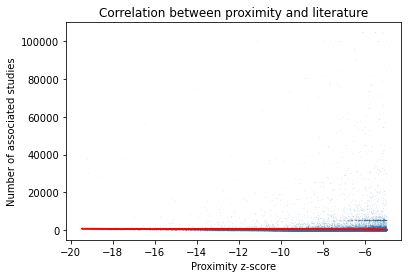

In [18]:
import scipy
from scipy import stats

prox_zscore=[] 
lit_annotation=[]

for couple,prox in real_significant_final_exp_proximity.items():
    prox_zscore.append(prox[1])
    lit_annotation.append(lit_associations_dis_chem_dict_real[couple])

print(scipy.stats.pearsonr(prox_zscore,lit_annotation))  # Pearson's r
print(scipy.stats.spearmanr(prox_zscore,lit_annotation)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(prox_zscore,lit_annotation)
fig, ax = plt.subplots()
ax.scatter(prox_zscore,lit_annotation, s= 0.001)
y=[]
for i in prox_zscore:
    g=(intercept + slope * i)
    y.append(g)


ax.plot(prox_zscore, y,color='r')
ax.set_xlabel('Proximity z-score')
ax.set_ylabel('Number of associated studies')

plt.title('Correlation between proximity and literature')
#ax.legend(facecolor='white')
plt.show()


(-0.018743193610603687, 4.708775223225086e-12)
SpearmanrResult(correlation=-0.049546289338744005, pvalue=1.059567827756352e-74)


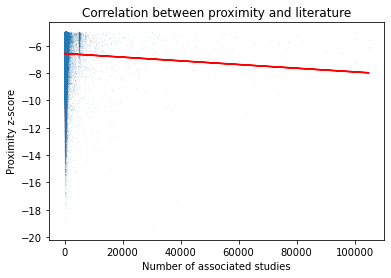

In [23]:
#Let's see what happens if I remove the 0 values

import scipy
from scipy import stats

prox_zscore_nozeroassociation=[] 
lit_annotation_nozeroassociation=[]

for couple,count in lit_associations_dis_chem_dict_real.items():
    if count!=0:
        prox_zscore_nozeroassociation.append(real_significant_final_exp_proximity[couple][1])
        lit_annotation_nozeroassociation.append(count)

print(scipy.stats.pearsonr(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation))  # Pearson's r
print(scipy.stats.spearmanr(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation)
fig, ax = plt.subplots()
ax.scatter(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation, s= 0.001)
y=[]
for i in lit_annotation_nozeroassociation:
    g=(intercept + slope * i)
    y.append(g)


ax.plot(lit_annotation_nozeroassociation, y,color='r')
ax.set_xlabel('Number of associated studies')
ax.set_ylabel('Proximity z-score')

plt.title('Correlation between proximity and literature')
#ax.legend(facecolor='white')
plt.show()



(-0.06500504325561146, 2.895806250729054e-123)
SpearmanrResult(correlation=-0.04891059084752858, pvalue=1.4983670872014403e-70)


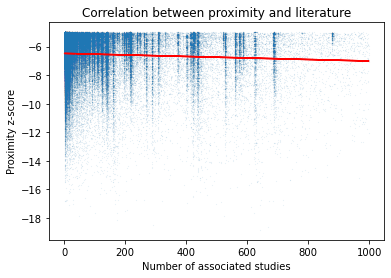

In [25]:
#Let's see what happens if I remove the 0 values and I limit the number of papers to 1000

import scipy
from scipy import stats

prox_zscore_nozeroassociation=[] 
lit_annotation_nozeroassociation=[]

for couple,count in lit_associations_dis_chem_dict_real.items():
    if count!=0 and count<1000:
        prox_zscore_nozeroassociation.append(real_significant_final_exp_proximity[couple][1])
        lit_annotation_nozeroassociation.append(count)

print(scipy.stats.pearsonr(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation))  # Pearson's r
print(scipy.stats.spearmanr(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation)
fig, ax = plt.subplots()
ax.scatter(lit_annotation_nozeroassociation,prox_zscore_nozeroassociation, s= 0.001)
y=[]
for i in lit_annotation_nozeroassociation:
    g=(intercept + slope * i)
    y.append(g)


ax.plot(lit_annotation_nozeroassociation, y,color='r')
ax.set_xlabel('Number of associated studies')
ax.set_ylabel('Proximity z-score')

plt.title('Correlation between proximity and literature')
#ax.legend(facecolor='white')
plt.show()


In [ ]:
#Binning values by proximity and take a certain number of random comparisons could give better results probably



In [ ]:
zscore_list=[]
for pair,stat in final_exp_proximity.items():
    zscore_list.append(stat[1])

In [ ]:
grouped_exp_by_zscore_dict={}
for el in list(range(-19,6)):
    exp_pair_list=[]
    for pair,stat in final_exp_proximity.items():
        if len(exp_pair_list)<1000:
            if el<stat[1]<el+1:
                exp_pair_list.append(pair)
            else:
                pass
        else:
            break
    grouped_exp_by_zscore_dict[el]=exp_pair_list

In [ ]:
from Bio import Entrez
Entrez.email = "yourmail@gmail.com"


grouped_exp_by_zscore_cit_count={}
for gr,exp_dis_pair_list in grouped_exp_by_zscore_dict.items():
    lit_associations_dis_chem_dict={}
    for exp_dis in exp_dis_pair_list:
        dis_chem_lit_association_list=[]
        try:
            handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(exp_dis[1],exp_dis[0]), retmax=100000, usehistory = 'y', retmode="xml")
            records = Entrez.read(handle)
            dis_chem_lit_association_list.extend(records["IdList"])
        except:
            pass  
        try:
            handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_name_id_conversion[exp_dis[1]],exp_dis[0]), retmax=100000, usehistory = 'y', retmode="xml")
            records = Entrez.read(handle)
            dis_chem_lit_association_list.extend(records["IdList"])
        except:
            pass
        try:
            handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(exp_dis[1],chem_id_name_conversion[exp_dis[0]]), retmax=100000, usehistory = 'y', retmode="xml")
            records = Entrez.read(handle)
            dis_chem_lit_association_list.extend(records["IdList"])
        except:
            pass  
        try:
            handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_name_id_conversion[exp_dis[1]],chem_id_name_conversion[exp_dis[0]]), retmax=100000, usehistory = 'y', retmode="xml")
            records = Entrez.read(handle)
            dis_chem_lit_association_list.extend(records["IdList"])
        except:
            pass
        try:
            handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(exp_dis_pair_list[1],chem_id_cas_conversion[exp_dis[0]]), retmax=100000, usehistory = 'y', retmode="xml")
            records = Entrez.read(handle)
            dis_chem_lit_association_list.extend(records["IdList"])
        except:
            pass  
        try:
            handle = Entrez.esearch(db="pubmed", term="%s AND %s" %(dis_name_id_conversion[exp_dis[1]],chem_id_cas_conversion[exp_dis[0]]), retmax=100000, usehistory = 'y', retmode="xml")
            records = Entrez.read(handle)
            dis_chem_lit_association_list.extend(records["IdList"])
        except:
            pass         
        lit_associations_dis_chem_dict[exp_dis]=len(set(dis_chem_lit_association_list))
    grouped_exp_by_zscore_cit_count[gr]=lit_associations_dis_chem_dict
    

In [ ]:
with open('output/exp_random/grouped_exp_by_zscore_cit_count.pickle', 'wb') as handle:
    pk.dump(grouped_exp_by_zscore_cit_count, handle, protocol=pk.HIGHEST_PROTOCOL)

In [4]:
import pickle as pk
with open('output/exp_random/grouped_exp_by_zscore_cit_count.pickle', 'rb') as handle:
    grouped_exp_by_zscore_cit_count = pk.load(handle)

In [14]:


exp_id_list = []
dis_name_list = []
prox_zcore_list = []
n_citations = []
for prox,expdiscit in grouped_exp_by_zscore_cit_count.items():
    for expdis,cit in expdiscit.items():
        exp_id_list.append(expdis[0])
        dis_name_list.append(expdis[1])
        n_citations.append(cit)
        prox_zcore_list.append(str(prox))

exp_dis_cit_df = pd.DataFrame()
exp_dis_cit_df["Exposure ID"] = exp_id_list
exp_dis_cit_df["Disease Name"] = dis_name_list
exp_dis_cit_df["Proximity z-score"] = prox_zcore_list
exp_dis_cit_df["Number of Co-Citations"] = n_citations
exp_dis_cit_df.to_csv("output/random_grouped_exp_dis_cit_df.tsv",sep="\t")

In [5]:

rows = []

for gr, count_dict in grouped_exp_by_zscore_cit_count.items():
    for pair, count in count_dict.items():
        rows.append({
            "Count": count,
            "Group": gr
        })

exp_grouped_count_df = pd.DataFrame(rows)

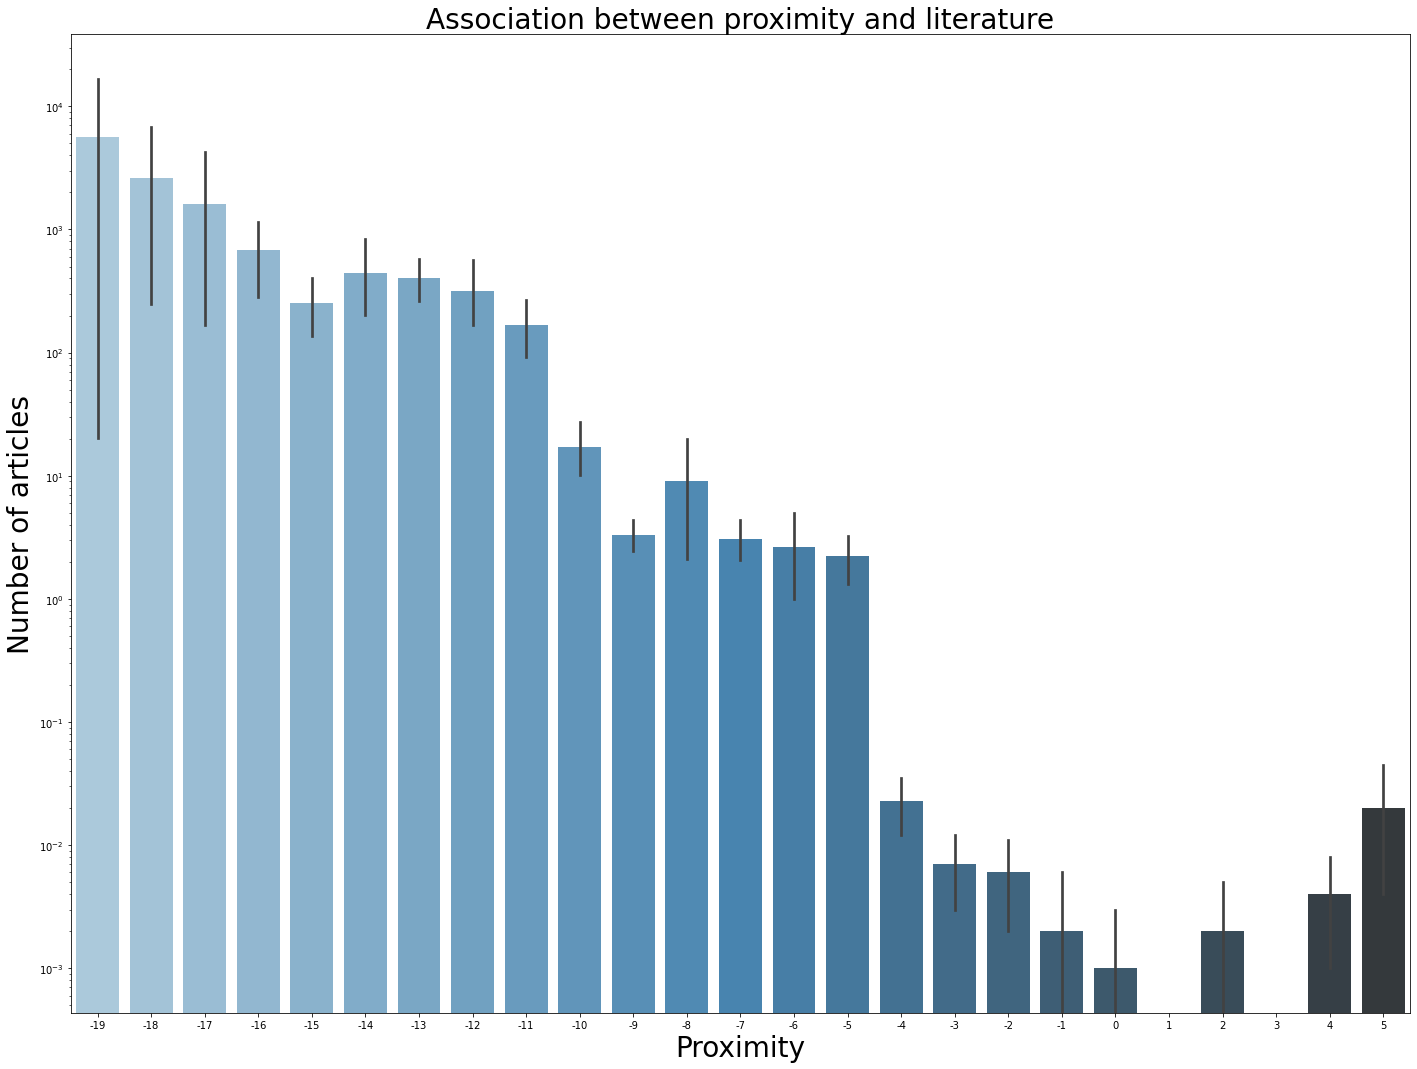

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Group", y="Count", data=exp_grouped_count_df,
                 palette="Blues_d")
ax.set_yscale("log")
ax.set_title("Association between proximity and literature",fontsize=28)
ax.set_ylabel("Number of articles",fontsize=28)
ax.set_xlabel("Proximity",fontsize=28)
plt.show()
#vertical lines are error bars

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_42131/2711968691.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_42131/2711968691.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(proximity_x, size = 36)


ValueError: Key pgf.preamble: Could not convert ['\\usepackage{arev}', '\\usepackage[T1]{fontenc}'] to str

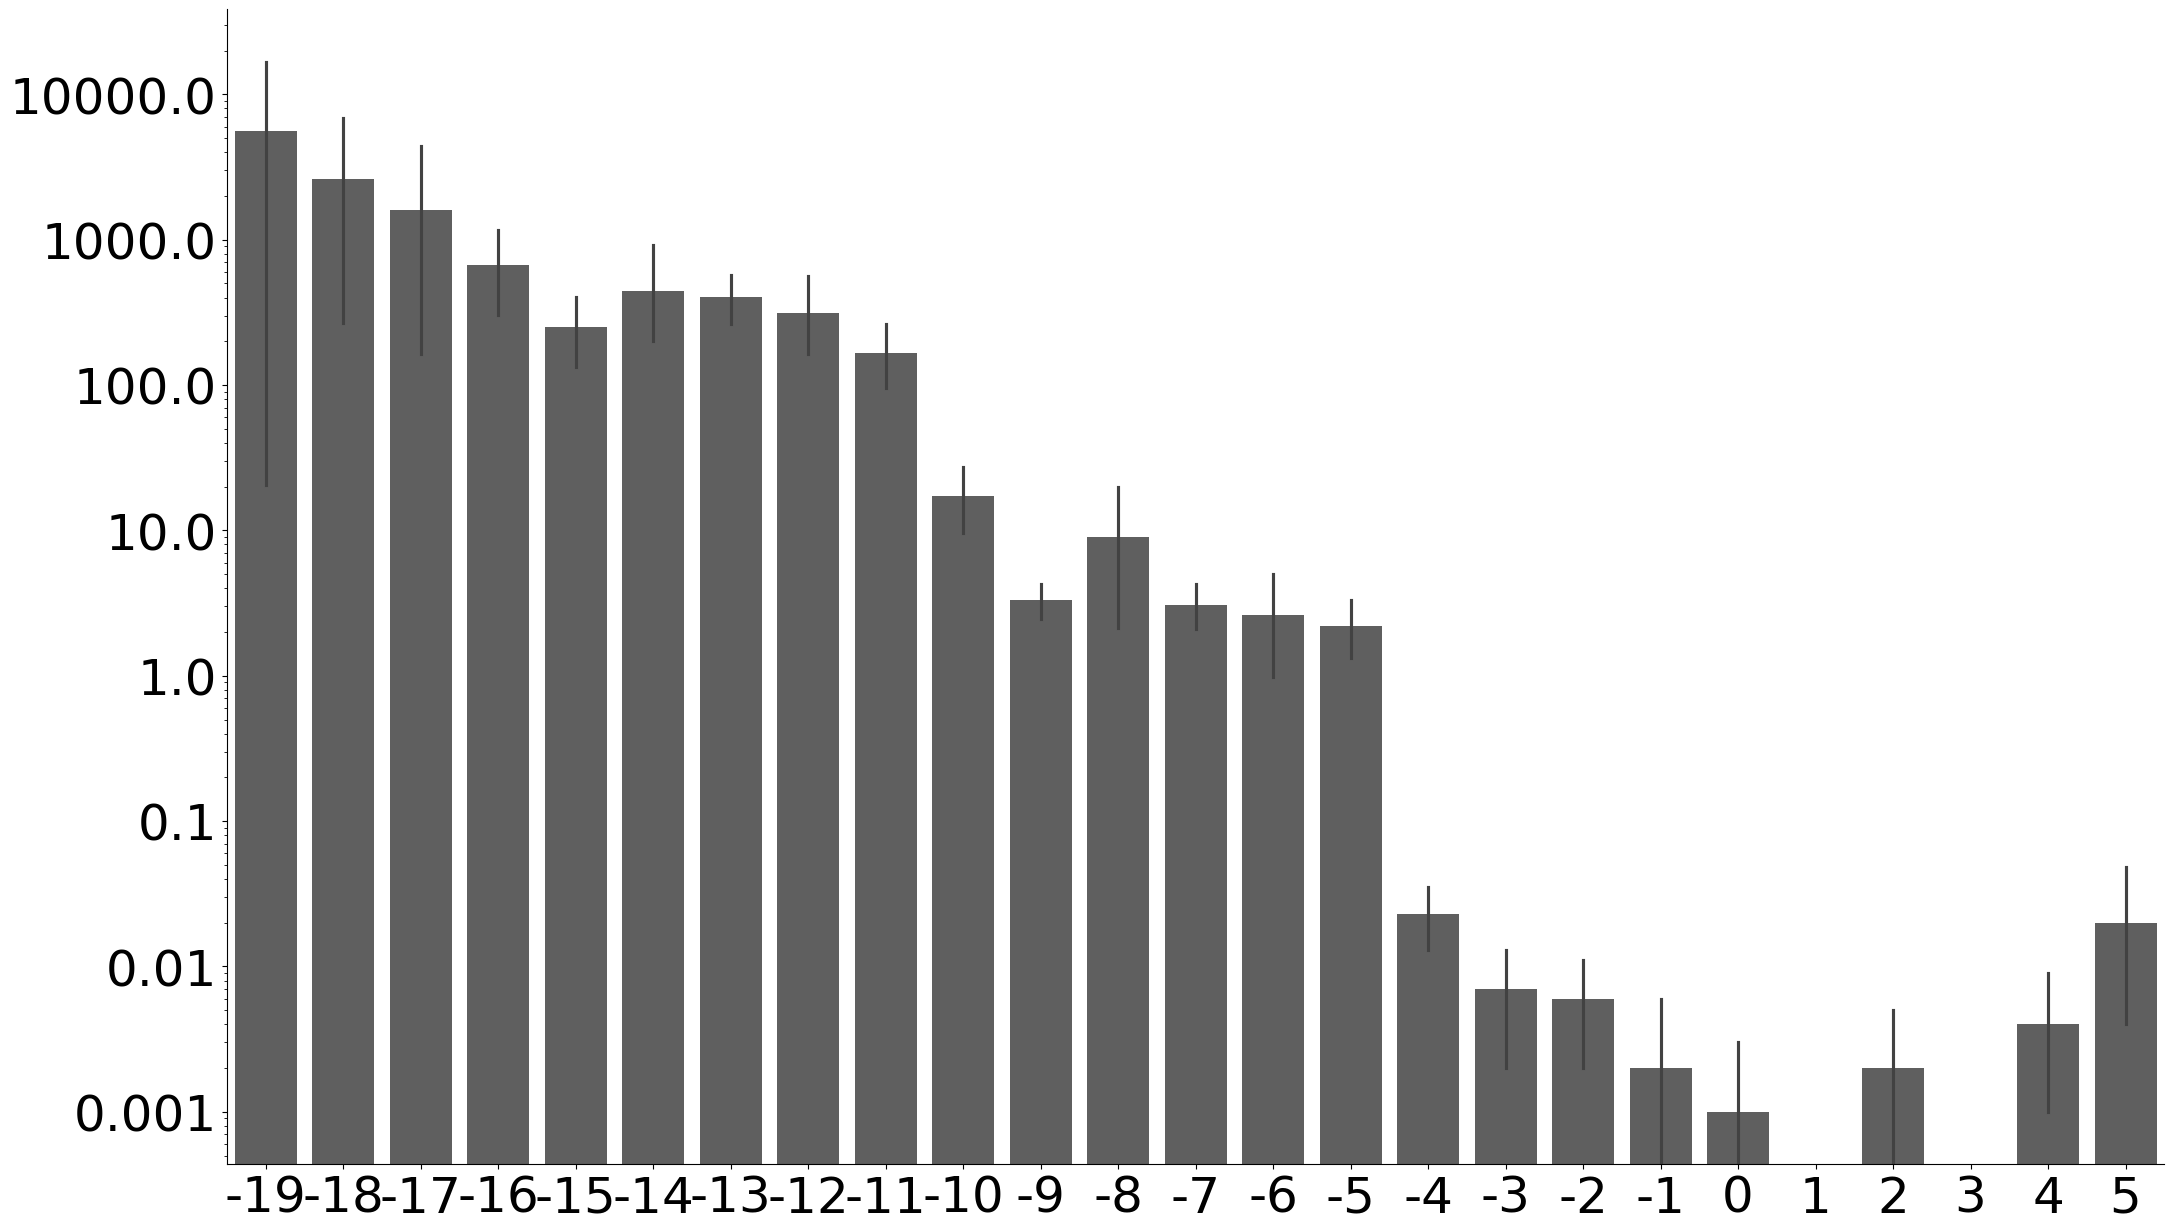

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.barplot(x="Group", y="Count", data=exp_grouped_count_df,
                 color="#5F5F5F")
ax.set_yscale("log")
#ax.set_title("Association between proximity and literature",fontsize=28)
proximity_x=list(range(-19,6))
ax.set_ylabel("",fontsize=28)
ax.set_xlabel("",fontsize=28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels(ax.get_yticks(), size = 36)
ax.set_xticklabels(proximity_x, size = 36)
import matplotlib
matplotlib.pyplot.rcParams.update({
    "pgf.preamble": [
         "\\usepackage{arev}",
        "\\usepackage[T1]{fontenc}"]
})

#plt.savefig('output/Figures/Figure4B.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [8]:

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    exp_grouped_count_df.to_excel(
        writer,
        sheet_name="Fig4B",
        index=False
    )